In [176]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as plt
import itertools
import os
import community
import csv
from collections import defaultdict
from sklearn.metrics.cluster import normalized_mutual_info_score

from random import random 
%matplotlib inline

### Problem 1

In [ ]:
mat = np.array(
[
    [0.258, 0.016, 0.035, 0.013],
    [0.012, 0.157, 0.058, 0.019],
    [0.013, 0.023, 0.306, 0.035],
    [0.005, 0.007, 0.024, 0.016],
]
)

Q = 0
ethnicity = ['b', 'h', 'w', 'o']
for i, row in enumerate(mat):
    a = sum(row)
    e = row[i]
    Q += e - a**2
    print('a_'+str(ethnicity[i]) + '=' + str(a) +'\n')
    print('e_'+ str(ethnicity[i]) + str(ethnicity[i]) + '=' + str(e) +'\n')
Q

In [ ]:
tmat = mat.transpose()
Qt = 0
for i, row in enumerate(tmat):
    a = sum(row)
    b = row[i]
    Qt += b - a**2
    print('a_'+str(ethnicity[i]) + '=' + str(a) +'\n')
    print('e_'+ str(ethnicity[i]) + str(ethnicity[i]) + '=' + str(e) +'\n')
Qt

### Problem 3 (First Attempt)

In [187]:
def initialize_labels(G):
    for i in range(1, G.number_of_nodes()+1):
        G.node[str(i)]['label'] = i
    return G

In [188]:
def get_labels(G):
    labels = []
    for i in range(1, G.number_of_nodes()+1):
        labels.append(G.node[str(i)]['label'])
    return list(set(labels))

In [189]:
def get_e_mat(G):
    A = nx.adjacency_matrix(G).todense().tolist()
    labels = get_labels(G)
    e_mat = np.zeros((len(labels), len(labels)))
    m = G.number_of_edges()
    for u in range(len(labels)):
        for v in range(len(labels)):
            for i in range(len(A)):
                for j in range(len(A)):
                    if G.node[str(i + 1)]['label'] == labels[u] and G.node[str(j+1)]['label'] == labels[v]:
                        e_mat[u][v] += A[i][j]
#                         print(e_mat[u][v])
    for u in range(len(labels)):
        for v in range(len(labels)):
            e_mat[u][v] = e_mat[u][v] / (2 * m)
    return e_mat

In [190]:
def get_delta_q(e_mat, labels):
    Q = -1
    merge_labels = None
    # Identify the two labels which, when merged will maximize Q
    for u in range(e_mat.shape[0]):
        for v in range(e_mat.shape[1]):
            if u == v:
                continue
            tmp_Q = 2 * (e_mat[u][v] - np.sum(e_mat[u]) * np.sum(e_mat[v]))
            if tmp_Q > Q:
                Q = tmp_Q
                merge_labels = [labels[u], labels[v]]
    return merge_labels, Q

In [191]:
def merge(G, merge_labels):
    min_merge = min(merge_labels)
    max_merge = max(merge_labels)
    for i in range(1, G.number_of_nodes()+1):
        if G.node[str(i)]['label'] == int(max_merge):
            G.node[str(i)]['label'] = int(min_merge)
    return G

In [192]:
def initialize(G):
    a_dict = {}
    m = G.number_of_edges()
    degrees = G.degree()
    for key in degrees.keys():
        a = (degrees[key]/(2*m))
        a_dict[key] = a
    return a_dict
        

In [193]:
def first_run(a_dict, G):
    delta_Q = -1
    best_combination = None
    combinations = list(itertools.combinations(a_dict.keys(), 2))
    #get biggest increase in Q
    for i, combination in enumerate(combinations):
#         print('combination ' +str(i)+ ' out of ' + str(len(combinations) ))
        g = merge(G, combination)
        e_mat = get_e_mat(G=g)
        labels = get_labels(g)
        _, tmp_q = get_delta_q(e_mat, labels)
#         d_Q = -2*(a_dict[combination[0]] * a_dict[combination[1]])
        if tmp_q > delta_Q:
            delta_Q = tmp_q
            best_combination = combination
    return best_combination, delta_Q

In [194]:
def get_groups(G):
    groups = defaultdict(list)
    # For each remaining group, create a list of nodes which belong to that group
    for i in range(1, G.number_of_nodes() + 1):
        groups[G.node[str(i)]['label']].append(i)
    return groups

In [195]:
def draw_network(G):
    groups = get_groups(G)
    colors = [(random(), random(), random()) for i in range(len(groups.keys()))]
    pos = nx.spring_layout(G)
    for i, key in enumerate(groups.keys()):
#         print("Drawing nodes: " + groups[key])
        nodelist = [str(i) for i in groups[key]]
        nx.draw_networkx_nodes(G, pos, nodelist = nodelist, node_color=colors[i], node_size=500)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)


In [196]:
def greedy_algorithm_1():
    ctr = 0
    delta_Q_list = []
    merge_list = []
    G = nx.read_edgelist('zkcc-77/karate_edges_77.txt')
    G = initialize_labels(G)
    labels = get_labels(G)
    # for first iteration, all e values are 0, so just use a's.
    a_dict = initialize(G)
    Q = init_modularity(G)
#     print(sum(a_dict.values()))
#     merge_labels, Q = first_run(a_dict, G)
#     print(merge_labels)
#     merge_labels = init_merge(G)
    merge_labels = [6, 17]
    G = merge(G, merge_labels)
    merge_list.append(merge_labels)
    prev_len = -1
#     while prev_len != len(labels):
    ctr = 0
    while len(labels) > 2:
#     while True:
        print(ctr)
        ctr+=1
        e_mat = get_e_mat(G)
        merge_labels, delta_Q = get_delta_q(e_mat, labels)
        if merge_labels == None:
#         if delta_Q < 0:
            break
        delta_Q_list.append(delta_Q)
        merge_list.append(merge_labels)
        G = merge(G, merge_labels)
        print(merge_labels)
        prev_len = len(labels)
        labels = get_labels(G)
        print(ctr)
        ctr+=1
    return G, delta_Q_list, merge_list

In [197]:
G, Q_list, merge_list = greedy_algorithm_1()

0
[6, 31]
1
2
[6, 10]
3
4
[1, 2]
5
6
[1, 6]
7
8
[1, 22]
9
10
[1, 4]
11
12
[1, 9]
13
14
[1, 20]
15
16
[1, 21]
17
18
[24, 27]
19
20
[15, 26]
21
22
[7, 15]
23
24
[34, 25]
25
26
[32, 25]
27
28
[24, 25]
29
30
[13, 16]
31
32
[5, 23]
33
34
[3, 18]
35
36
[12, 19]
37
38
[5, 29]
39
40
[1, 3]
41
42
[33, 24]
43
44
[13, 28]
45
46
[12, 13]
47
48
[8, 12]
49
50
[5, 8]
51
52
[7, 11]
53
54
[7, 30]
55
56
[1, 14]
57
58
[24, 5]
59
60
[1, 7]
61


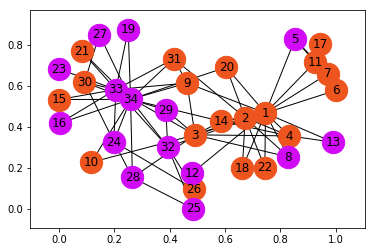

In [198]:
draw_network(G)

In [199]:
groups = get_groups(G)

In [200]:
groups

defaultdict(list,
            {1: [1,
              2,
              3,
              4,
              6,
              7,
              9,
              10,
              11,
              14,
              15,
              17,
              18,
              20,
              21,
              22,
              26,
              30,
              31],
             5: [5, 8, 12, 13, 16, 19, 23, 24, 25, 27, 28, 29, 32, 33, 34]})

In [ ]:
groups[1] = [str(i) for i in groups[1]]

In [ ]:
groups[1]

In [ ]:
Q_list

In [ ]:
# Density vs network size
from pylab import *
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plt.plot(sizes, [0 for i in sizes], color = 'k')
merges = [i for i in range(1, len(Q_list)+1)]
ax.scatter(merges, Q_list)

# plt.yscale('log')
plt.title('Status')
plt.xlabel('Network Size')
plt.ylabel("Status Modularity, Q")

In [ ]:
final_labels = get_labels(G)
final_labels

In [ ]:
groups = get_groups(G)

In [ ]:
groups

In [ ]:
total = [i for i in range(1, 35)]
red = [22, 18, 20, 8, 2, 4, 1, 3, 13, 6, 7, 5, 12, 14, 9, 17, 11]
blue = [i for i in total if i not in red]

In [ ]:
red = sorted(red)
blue = sorted(blue)
print(red)
print(blue)

In [ ]:
final_labels = get_labels(G)
nx.draw(G, node_color = colors)


In [ ]:
draw_network(G)

In [ ]:
final_labels = get_labels(G)

In [ ]:
len(final_labels)

### Debugging

In [ ]:
# Initial Step
G = nx.read_edgelist('zkcc-77/karate_edges_77.txt')
G = initialize_labels(G)
labels = get_labels(G)
a_dict = initialize(G)
best_combination, _ = first_run(a_dict)
G = merge(G, best_combination)

In [ ]:
# First iteration
e_mat = get_e_mat(G)
orig_emat = e_mat


In [ ]:
merge_labels, Q = get_delta_q(e_mat, labels)
G = merge(G, merge_labels)
labels = get_labels(G)


In [ ]:
merge_labels

In [ ]:
m = G.number_of_edges()
for u in range(len(labels)):
    for v in range(len(labels)):
#                     if i == len(A) + 1 and j == len(A) + 1:
        e_mat[u][v] = e_mat[u][v] / (2 * m)
e_mat

In [ ]:
G = nx.read_edgelist('zkcc-77/karate_edges_77.txt')

a_dict = initialize(G)
best_combination, Q = first_run(a_dict)

In [ ]:
best_combination

In [ ]:
a_dict

In [ ]:
labels = get_num_labels(G)

In [ ]:
list(labels)

In [ ]:
G.node['1']['label']

In [ ]:
a = np.array(
[
    [1, 2 ,3],
    [3, 2, 4],
    [1, 1, 1]
])

In [ ]:
b = np.sum(a[0])

In [ ]:
b

In [ ]:
import itertools
a = list(itertools.combinations(a_dict.keys(), 2))

In [ ]:
# Definition of delta q.
delta_q = 2.0 * ((num_edges_between_groups / (2* m)) - ((k_u * k_v) / ((2.0 * m) ** 2)))

## Problem 3 (Second Attempt)

In [140]:
def init_modularity(G):
#     A = nx.adjacency_matrix(G)
    modularity = 0
    degrees = G.degree()
    m = G.number_of_edges()
    # Sum of -a_i^2
    for key in degrees.keys():
        modularity -= (degrees[key]/(2 * m))**2
    return modularity

In [141]:
def initialize_labels(G):
    for i in range(1, G.number_of_nodes()+1):
        G.node[str(i)]['label'] = i
    return G

In [142]:
def get_labels(G):
    labels = []
    for i in range(1, G.number_of_nodes()+1):
        labels.append(G.node[str(i)]['label'])
    return list(set(labels))

In [143]:
def calc_num_edges(G, group1, group2):
#     Given a graph G, and two sets of nodes, calculate the total number of edges between those groups
    num_edges = 0
    edge_list = G.edges()
    for node1 in group1:
        for node2 in group2:
            if (str(node1), str(node2)) in edge_list or (str(node2), str(node1)) in edge_list:
                num_edges += 1
    return num_edges

In [144]:
def get_groups(G):
    groups = defaultdict(list)
    # For each remaining group, create a list of nodes which belong to that group
    for i in range(1, G.number_of_nodes() + 1):
        groups[G.node[str(i)]['label']].append(i)
    return groups

In [145]:
def calc_delta_Q(G):
    d_Q = -1
    best_combination = None
    degrees = G.degree()
    m = G.number_of_nodes()
    groups = get_groups(G)
#     print(groups)
    combinations = list(itertools.combinations(groups.keys(), 2))
    # a combination of different group labels
    for combination in combinations:
        num_edges_between_groups = calc_num_edges(G, groups[combination[0]], groups[combination[1]])
        k_u = sum([degrees[str(x)] for x in groups[combination[0]]])
        k_v = sum([degrees[str(y)] for y in groups[combination[1]]])
#         print(k_u)
#         print(k_v)
        d_q = 2.0 * ((num_edges_between_groups / (2.0 * m)) - ((k_u * k_v) / ((2.0 * m) ** 2)))
        if d_q > d_Q:
#             print('d_q ' + str(d_q))
            d_Q = d_q
            best_combination = combination
#     print(best_combination)
    return d_Q, best_combination

In [146]:
def merge(G, merge_labels):
    min_merge = min(merge_labels)
    max_merge = max(merge_labels)
    for i in range(1, G.number_of_nodes()+1):
        if G.node[str(i)]['label'] == int(max_merge):
            G.node[str(i)]['label'] = int(min_merge)
    return G

In [205]:
def greedy_algorithm_2():
    combinations_list = []
    Q_list = []
    # Read in graph
    G = nx.read_edgelist('zkcc-77/karate_edges_77.txt')
    # Apply unique labels to each node
    G = initialize_labels(G)
    labels = get_labels(G)
    # Compute initial modularity
    Q = init_modularity(G)
    prev_len = len(labels) + 1
    # While P has more than one group, i.e. while there is more than one label.
#     while len(labels) != prev_len:
#     while True:
    while(len(labels) > 2):
        prev_len = len(labels)
        # Calculate the best delta Q among all possible group mergers.
        delta_Q, best_combination = calc_delta_Q(G)
        if best_combination is not None:
            G = merge(G, best_combination)
            groups = get_groups(G)
#             if delta_Q < 0:
#                 break
            Q += delta_Q
            combinations_list.append(best_combination)
            Q_list.append(Q)
            labels = get_labels(G)
            groups = get_groups(G)
#             print(best_combination)
#             print(groups)
#             print('')
#         print(best_combination)
    return combinations_list, Q_list, G

In [207]:
combinations_list, Q_list, G = greedy_algorithm_2()

(6, 17)
defaultdict(<class 'list'>, {1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6, 17], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 27: [27], 28: [28], 29: [29], 30: [30], 31: [31], 32: [32], 33: [33], 34: [34]})

(6, 7)
defaultdict(<class 'list'>, {1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6, 7, 17], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 27: [27], 28: [28], 29: [29], 30: [30], 31: [31], 32: [32], 33: [33], 34: [34]})

(27, 30)
defaultdict(<class 'list'>, {1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6, 7, 17], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 27: [27, 30], 28: [28], 29:

In [162]:
combinations_list

[(6, 17),
 (6, 7),
 (27, 30),
 (5, 11),
 (5, 6),
 (25, 26),
 (25, 32),
 (4, 13),
 (23, 33),
 (1, 12),
 (2, 18),
 (3, 10),
 (9, 31),
 (24, 28),
 (2, 22),
 (15, 23),
 (34, 27),
 (15, 16),
 (4, 8),
 (15, 19),
 (3, 29),
 (15, 21),
 (2, 20),
 (25, 24),
 (4, 14),
 (1, 2),
 (3, 4),
 (9, 15),
 (9, 27),
 (1, 5),
 (24, 3),
 (1, 3)]

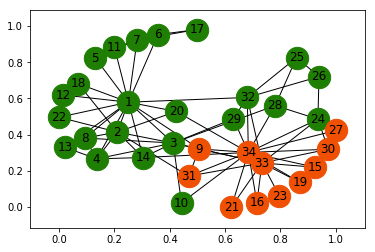

In [163]:
draw_network(G)

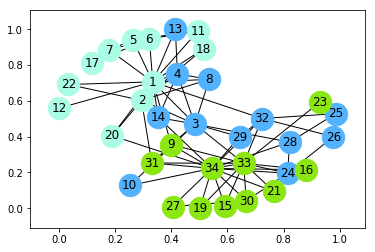

In [159]:
draw_network(G)

In [55]:
total = [i for i in range(1, 35)]
red = [22, 18, 20, 8, 2, 4, 1, 3, 13, 6, 7, 5, 12, 14, 9, 17, 11]
blue = [i for i in total if i not in red]

red = sorted(red)
blue = sorted(blue)
print(red)
print(blue)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 17, 18, 20, 22]
[10, 15, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [57]:
groups = get_groups(G)
groups

defaultdict(list,
            {1: [1,
              2,
              3,
              4,
              5,
              6,
              7,
              8,
              10,
              11,
              12,
              13,
              14,
              17,
              18,
              20,
              22,
              24,
              25,
              26,
              28,
              29,
              32],
             9: [9, 15, 16, 19, 21, 23, 27, 30, 31, 33, 34]})

In [174]:
groups[1]

[1, 2, 5, 6, 7, 11, 12, 17, 18, 20, 22]

In [183]:
# NMI
def get_NMI(G):
    # red is 1, blue is 0
    true_labels = []
    groups = get_groups(G)
    group1 = groups[1]
    pred_labels = []

    for i in range(1, 34):
        if i in red:
            true_labels.append(1)
        else:
            true_labels.append(0)
        if i in group1:
            pred_labels.append(0)
        else:
            pred_labels.append(1)
            
    return normalized_mutual_info_score(pred_labels, true_labels)

In [201]:
nmi = get_NMI(G)
nmi

0.11613838906768294

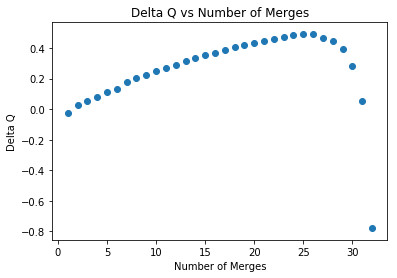

In [208]:
# Density vs network size
from pylab import *
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plt.plot(sizes, [0 for i in sizes], color = 'k')
merges = [i for i in range(1, len(Q_list)+1)]
ax.scatter(merges, delta_Q_list)

# plt.yscale('log')
plt.title('Delta Q vs Number of Merges')
plt.xlabel('Number of Merges')
plt.ylabel("Delta Q")

In [ ]:
groups = get_groups(G)
for value in groups.values():
    print(value)

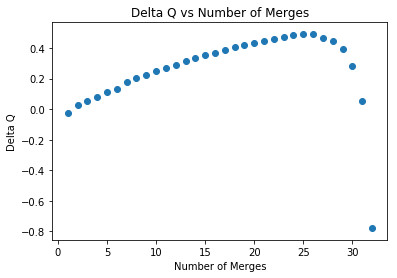

In [208]:
# Density vs network size
from pylab import *
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plt.plot(sizes, [0 for i in sizes], color = 'k')
merges = [i for i in range(1, len(Q_list)+1)]
ax.scatter(merges, delta_Q_list)

# plt.yscale('log')
plt.title('Delta Q vs Number of Merges')
plt.xlabel('Number of Merges')
plt.ylabel("Delta Q")

In [ ]:
def old_greedy_algorithm():
    ctr = 0
    Q_list = []
    merge_list = []
    G = nx.read_edgelist('zkcc-77/karate_edges_77.txt')
    G = initialize_labels(G)
    labels = get_labels(G)
    # for first iteration, all e values are 0, so just use a's.
    a_dict = initialize(G)
    merge_labels, _ = first_run(a_dict)
    G = merge(G, merge_labels)
    merge_list.append(merge_labels)
    prev_len = -1
    while prev_len != len(labels):
        e_mat = get_e_mat(G)
        merge_labels, Q = get_delta_q(e_mat, labels)
        Q_list.append(Q)
        merge_list.append(merge_labels)
        G = merge(G, merge_labels)
        print(merge_labels)
        prev_len = len(labels)
        labels = get_labels(G)
        print(ctr)
        ctr+=1
    return G, Q_list, merge_list

In [ ]:
a = G.degree()

### Problem 4

In [262]:
datasets = [dataset for dataset in os.listdir('facebook100txt/') if dataset[-4:] == '.txt']    
edges = [data for data in datasets if '_attr.txt' not in data]
attr = [data for data in datasets if '_attr' in data]
final_pairs = []
networks_list = []
for name in attr:
    data = name.split('_attr')
    if name not in os.listdir('facebook100txt/'):
        print("Couldnt find {}".format(name))
        continue
    if ''.join(data) not in os.listdir('facebook100txt/'):
        print("Couldnt find {}".format(''.join(data)))
        continue
    final_pairs.append([''.join(data), name])


In [263]:
# Takes as input a textfile with n rows of attributes (n = number of nodes)
# Returns a list of n dictionaries
def create_attributes_dict(attributes_list):
    results_list = []
    with open('facebook100txt/{}'.format(attributes_list), 'r') as infile:
        for row in csv.DictReader(infile, delimiter='\t'):
            results_list.append(row)
    return results_list

In [264]:
def create_network(edge_list, attributes):
    G = nx.read_edgelist('facebook100txt/' + edge_list)
    for i in range(1, G.number_of_nodes() + 1):
        attr_dict = attributes[i -1]
        for key in attr_dict.keys():
            G.node[str(i)][key] = attr_dict[key]
    return G

In [265]:
# Create a Graph with attributes
attributes = create_attributes_dict(final_pairs[1][1])
G = create_network(final_pairs[1][0], attributes)

In [266]:
# graph_list = []
status_modularities = []
major_modularities = []
degree_modularities = []
network_size = []
for pair in final_pairs:
    print("Creating graph for " + pair[0])
    attributes = create_attributes_dict(pair[1])
    G = create_network(pair[0], attributes)
    status_modularities.append([pair[0][:-4], nx.attribute_assortativity_coefficient(G, 'status')])
    major_modularities.append([pair[0][:-4], nx.attribute_assortativity_coefficient(G, 'major')])
    degree_modularities.append([pair[0][:-4], nx.degree_assortativity_coefficient(G)])
    network_size.append([pair[0][:-4], G.number_of_nodes()])

Creating graph for Tufts18.txt
Creating graph for Mich67.txt
Creating graph for Maryland58.txt
Creating graph for Wake73.txt
Creating graph for GWU54.txt
Creating graph for Tulane29.txt
Creating graph for Rice31.txt
Creating graph for Michigan23.txt
Creating graph for Cornell5.txt
Creating graph for Villanova62.txt
Creating graph for Howard90.txt
Creating graph for UConn91.txt
Creating graph for Auburn71.txt
Creating graph for MSU24.txt
Creating graph for Penn94.txt
Creating graph for USC35.txt
Creating graph for Stanford3.txt
Creating graph for UPenn7.txt
Creating graph for Northwestern25.txt
Creating graph for Northeastern19.txt
Creating graph for Amherst41.txt
Creating graph for BC17.txt
Creating graph for UVA16.txt
Creating graph for MIT8.txt
Creating graph for Carnegie49.txt
Creating graph for Dartmouth6.txt
Creating graph for UCF52.txt
Creating graph for UNC28.txt
Creating graph for UF21.txt
Creating graph for UCSD34.txt
Creating graph for Reed98.txt
Creating graph for Johns Hopk

In [267]:
gender_modularities = []
for pair in final_pairs:
    print("Creating graph for " + pair[0])
    attributes = create_attributes_dict(pair[1])
    G = create_network(pair[0], attributes)
    gender_modularities.append([pair[0][:-4], nx.attribute_assortativity_coefficient(G, 'gender')])
#     network_size.append([pair[0][:-4], G.number_of_nodes()])

Creating graph for Tufts18.txt
Creating graph for Mich67.txt
Creating graph for Maryland58.txt
Creating graph for Wake73.txt
Creating graph for GWU54.txt
Creating graph for Tulane29.txt
Creating graph for Rice31.txt
Creating graph for Michigan23.txt
Creating graph for Cornell5.txt
Creating graph for Villanova62.txt
Creating graph for Howard90.txt
Creating graph for UConn91.txt
Creating graph for Auburn71.txt
Creating graph for MSU24.txt
Creating graph for Penn94.txt
Creating graph for USC35.txt
Creating graph for Stanford3.txt
Creating graph for UPenn7.txt
Creating graph for Northwestern25.txt
Creating graph for Northeastern19.txt
Creating graph for Amherst41.txt
Creating graph for BC17.txt
Creating graph for UVA16.txt
Creating graph for MIT8.txt
Creating graph for Carnegie49.txt
Creating graph for Dartmouth6.txt
Creating graph for UCF52.txt
Creating graph for UNC28.txt
Creating graph for UF21.txt
Creating graph for UCSD34.txt
Creating graph for Reed98.txt
Creating graph for Johns Hopk

In [268]:
import pprint
pp = pprint.PrettyPrinter()
print("Status")
pp.pprint(status_modularities)
print("\nMajor")
pp.pprint(major_modularities)
print("\nDegree")
pp.pprint(degree_modularities)
print("\n Size")
pp.pprint(network_size)

Status
[['Tufts18', 0.4321627171114533],
 ['Mich67', 0.22862773749288545],
 ['Maryland58', 0.2733177114509532],
 ['Wake73', 0.34675911178101015],
 ['GWU54', 0.35817720136089604],
 ['Tulane29', 0.38802299607825214],
 ['Rice31', 0.35751693850145505],
 ['Michigan23', 0.3439781874719799],
 ['Cornell5', 0.40567620470338744],
 ['Villanova62', 0.46085880060278733],
 ['Howard90', 0.27962718528340236],
 ['UConn91', 0.24631695232384726],
 ['Auburn71', 0.19188583301598053],
 ['MSU24', 0.2823228667806069],
 ['Penn94', 0.24324861264934874],
 ['USC35', 0.2757015432852803],
 ['Stanford3', 0.3594058116771138],
 ['UPenn7', 0.43274598384527135],
 ['Northwestern25', 0.36216810374024144],
 ['Northeastern19', 0.2735772760321271],
 ['Amherst41', 0.4034107230365701],
 ['BC17', 0.5331807976868098],
 ['UVA16', 0.39499353105142343],
 ['MIT8', 0.3152408596024683],
 ['Carnegie49', 0.3114088407237661],
 ['Dartmouth6', 0.4122022116147316],
 ['UCF52', 0.12512677875910128],
 ['UNC28', 0.2977830668869021],
 ['UF21', 0

In [269]:
import seaborn as sns

In [270]:
sizes = [value[1] for value in network_size]
majors = [value[1] for value in major_modularities]
degrees = [value[1] for value in degree_modularities]
statuses = [value[1] for value in status_modularities]

## Making plots of data

In [271]:
type(degrees)

list

In [272]:
new_degrees = []
for val in degrees:
    new_degrees.append(val)

In [273]:
test

<bound method NoseTester.test of <numpy.testing.nosetester.NoseTester object at 0x7f39303bbf60>>

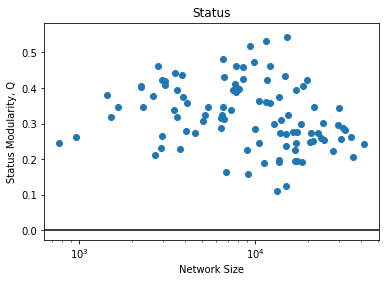

In [274]:
# Density vs network size
from pylab import *
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plt.plot(sizes, [0 for i in sizes], color = 'k')

ax.axhline(y=0, color='k')
ax.scatter(sizes, statuses)

# plt.yscale('log')
plt.xscale('log')
plt.title('Status')
plt.xlabel('Network Size')
plt.ylabel("Status Modularity, Q")

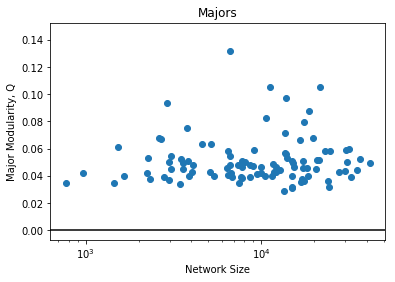

In [275]:
# Density vs network size
from pylab import *
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plt.plot(sizes, [0 for i in sizes], color = 'k')

ax.axhline(y=0, color='k')
ax.scatter(sizes, majors)

# plt.yscale('log')
plt.xscale('log')
plt.title('Majors')
plt.xlabel('Network Size')
plt.ylabel("Major Modularity, Q")

NameError: name 'genders' is not defined

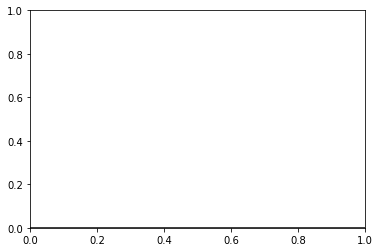

In [279]:
# Density vs network size
from pylab import *
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plt.plot(sizes, [0 for i in sizes], color = 'k')

ax.axhline(y=0, color='k')
ax.scatter(sizes, genders)

# plt.yscale('log')
plt.xscale('log')
plt.title('Genders')
plt.xlabel('Network Size')
plt.ylabel("Gender Modularity, Q")

sizes 100


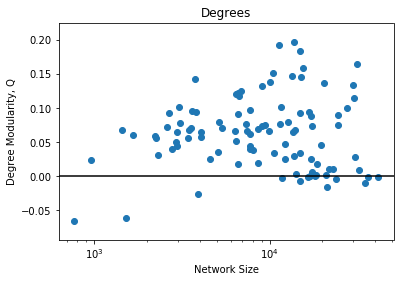

In [277]:
from pylab import *
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plt.plot(sizes, [0 for i in sizes], color = 'k')

ax.axhline(y=0, color='k')
print('sizes ' + str(len(sizes)))
# print('degrees ' + str(len(degrees)))
ax.scatter(sizes, new_degrees)

# plt.yscale('log')
plt.xscale('log')
plt.title('Degrees')
plt.xlabel('Network Size')
plt.ylabel("Degree Modularity, Q")

In [278]:
from scipy.stats import gaussian_kde
density = gaussian_kde(majors)
# xs = np.linspace(0,8,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))



NameError: name 'xs' is not defined

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(np.array(majors))
plt.vlines(x=0, ymin = 0, ymax = 50)
plt.title('Majors')
plt.xlabel('Assortativity(Majors)')
plt.ylabel("Density")

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(np.array(new_degrees))
plt.vlines(x=0, ymin = 0, ymax = 10)
plt.title('Degrees')
plt.xlabel('Assortativity(Degrees)')
plt.ylabel("Density")

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(np.array(statuses))
plt.vlines(x=0, ymin = 0, ymax = 5)
plt.title('Status')
plt.xlabel('Assortativity(Status)')
plt.ylabel("Density")

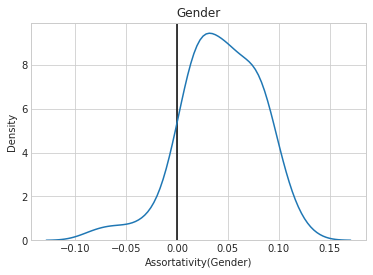

In [280]:
import seaborn as sns
genders = [val[1] for val in gender_modularities]
sns.set_style('whitegrid')
sns.kdeplot(np.array(genders))
plt.vlines(x=0, ymin = 0, ymax = 10)
plt.title('Gender ')
plt.xlabel('Assortativity(Gender)')
plt.ylabel("Density")

In [ ]:
import csv
fb_attr_dir = 'facebook100txt/'
for file in os.listdir(fb_attr_dir):
    if file.endswith('txt'):
        filepath = fb_attr_dir + file
        college_name = file.split('_')[0].lower()
        with open(filepath, 'r') as attr_file:
            reader = csv.DictReader(attr_file, delimiter='\t')
            # headers = reader.next()
            graph = graph_list[college_name]
            status = {}
            majors = {}
            degree = {}
            print(college_name + " processing")
            for i, row in enumerate(reader):
                # each line corresponds to a vertex in the graph
                i_node = str(i + 1)
                status[i_node] = int(row['status'])
                majors[i_node] = int(row['major'])
            
            nx.set_node_attributes(graph, status,'status')
            nx.set_node_attributes(graph, majors, 'major')

In [ ]:
for name, graph in graph_list.items():
    print('processing ' + name)
    degree_mods.append(nx.degree_assortativity_coefficient(graph))
    major_mods.append(nx.attribute_assortativity_coefficient(graph, 'major'))
    status_mods.append(nx.attribute_assortativity_coefficient(graph, 'status'))
    network_size.append(graph.number_of_nodes())

In [ ]:
a = [
    [1, 2],
    [9, 3]
]

In [ ]:
b = [[min(val), max(val)] for val in a]

In [ ]:
c = set(b)

## HAIL MARY

In [ ]:
combinations_list, Q_list, G = greedy_algorithm_2()

In [ ]:
combinations_list

In [ ]:
draw_network(G)

In [ ]:
draw_network(G)

In [ ]:
draw_network(G)

In [ ]:
total = [i for i in range(1, 35)]
red = [22, 18, 20, 8, 2, 4, 1, 3, 13, 6, 7, 5, 12, 14, 9, 17, 11]
blue = [i for i in total if i not in red]

red = sorted(red)
blue = sorted(blue)
print(red)
print(blue)

In [ ]:
groups = get_groups(G)
groups

In [ ]:
groups[1]

In [ ]:
# NMI
def get_NMI(G):
    # red is 1, blue is 0
    true_labels = []
    groups = get_groups(G)
    group1 = groups[1]
    pred_labels = []

    for i in range(1, 34):
        if i in red:
            true_labels.append(1)
        else:
            true_labels.append(0)
        if i in group1:
            pred_labels.append(0)
        else:
            pred_labels.append(1)
            
    return normalized_mutual_info_score(pred_labels, true_labels)

In [ ]:
nmi = get_NMI(G)
nmi

In [ ]:
# Density vs network size
from pylab import *
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plt.plot(sizes, [0 for i in sizes], color = 'k')
merges = [i for i in range(1, len(Q_list)+1)]
ax.scatter(merges, delta_Q_list)

# plt.yscale('log')
plt.title('Delta Q vs Number of Merges')
plt.xlabel('Number of Merges')
plt.ylabel("Delta Q")